In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split,KFold
from gensim.models.word2vec import Word2Vec
from tqdm.cli import tqdm

%matplotlib inline

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv("./clean_text.csv")

In [4]:
df.head()

,target,text
0,0,<username> <url> awww that's a bummer you shou...
1,0,is upset that he can't update his facebook by ...
2,0,<username> i dived many times for the ball man...
3,0,my whole body feels itchy and like its on fire
4,0,<username> no it's not behaving at all i'm mad...


In [5]:
df.target.unique()

array([0, 4])

In [6]:
df['target'] = df.target.apply(lambda x:int(x//4))

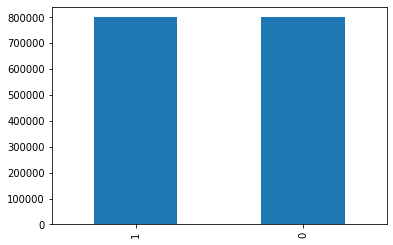

In [7]:
df.target.value_counts().plot.bar()

In [8]:
sentences = df.text.apply(lambda x:x.split(" ")).values

In [9]:
wv = Word2Vec(sentences=sentences,size=48,min_count=1).wv

In [10]:
sentences = np.array(list(map(np.array,sentences)))

In [11]:
max_len = max(list(map(len,sentences)))

In [12]:
max_len

118

In [13]:
dummy = np.zeros((1,48,))
def vectorize(x):
    return wv[x[0]]

def apply_vectorize(sent):
    sent, = sent
    return np.concatenate((
        np.apply_along_axis(vectorize,1,sent.reshape(-1,1)),
        np.repeat(dummy,max_len-len(sent),axis=0)
    ))

In [14]:
%%time
v = np.apply_along_axis(apply_vectorize,1,sentences[0:32].reshape(-1,1))

CPU times: user 8.47 ms, sys: 6 µs, total: 8.48 ms
Wall time: 7.76 ms


In [15]:
X,x_,Y,y_ = train_test_split(sentences,df.target.values,shuffle=True,random_state=42,test_size=0.15)

In [16]:
class Dataset:
    def __init__(self,x,y,):
        self.x = x
        self.y = y
        
    def __len__(self,):
        return len(self.x)
        
    def _flow(self,):
        br = len(self) % self.batch_size
        while True:
            idx = np.random.permutation(len(self))
            for batch in idx[br:].reshape(-1,self.batch_size):
                yield np.apply_along_axis(apply_vectorize,1,self.x[batch].reshape(-1,1)),self.y[batch]
            if br:
                yield np.apply_along_axis(apply_vectorize,1,self.x[idx[:br]].reshape(-1,1)),self.y[idx[:br]]
            
    def get_flow(self,batch_size:int):
        self.batch_size = batch_size
        return self._flow(),np.ceil(len(self)/batch_size).astype(int)

In [17]:
train_ds = Dataset(X,Y)
test_ds = Dataset(x_,y_)

In [18]:
def timedist(x,units,activation=ReLU(4.5),dropout=0):
    x = TimeDistributed(Dense(units,use_bias=False))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    if dropout:
        x = Dropout(dropout)(x)
    return x

em_in = Input(shape=(118,48))

x = timedist(em_in,1024,dropout=0.15)
x = GlobalAveragePooling1D()(x)

x = Dense(1,)(x)
x = BatchNormalization()(x)
out = Activation('sigmoid')(x)

model = Model(em_in,out)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 118, 48)]         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 118, 1024)         49152     
_________________________________________________________________
batch_normalization (BatchNo (None, 118, 1024)         4096      
_________________________________________________________________
activation (Activation)      (None, 118, 1024)         0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 1024)         0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025  

In [20]:
loss = keras.losses.BinaryCrossentropy()
opt = keras.optimizers.Adam(0.00009)

model.compile(loss=loss,optmizer=opt,metrics=['accuracy'])

In [21]:
train_flow,train_spe = train_ds.get_flow(128)
test_flow,test_spe = test_ds.get_flow(128)

In [ ]:
model.fit_generator(
    generator=train_flow,
    steps_per_epoch=train_spe,
    validation_data=test_flow,
    validation_steps=test_spe,
    epochs=3
)

Epoch 1/3
 3411/10625 [========>.....................] - ETA: 11:36 - loss: 0.5105 - accuracy: 0.7591